In [1]:
# Function to perform trypsin digestion, used for normalizing unique peptide counts

import requests
from pyopenms import ProteaseDigestion, AASequence

def normalize_unique_peptides(df, accession_col="accession", unique_count_col="Unique count(sequence)", min_peptide_length=3):
    """
    Process a DataFrame to fetch sequences, perform trypsin digestion, 
    and normalize unique peptide counts based on theoretical peptide counts.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame with accession numbers and unique peptide counts.
    - accession_col (str): Column name for protein accession numbers.
    - unique_count_col (str): Column name for unique peptide counts.
    - min_peptide_length (int): Minimum length of peptides to include in the count.

    Returns:
    - pd.DataFrame: Updated DataFrame with sequences, theoretical peptide counts, and normalized unique counts.
    """

    # Set up trypsin digestion
    digestion = ProteaseDigestion()
    digestion.setEnzyme("Trypsin")  # Set to Trypsin
    digestion.setMissedCleavages(0)  # Adjust as desired

    # Function to count peptides longer than a specified number of amino acids
    def count_long_peptides(sequence, min_length=min_peptide_length):
        if sequence is None:  # Handle missing sequences
            return 0
        
        # Convert sequence to AASequence
        aa_sequence = AASequence.fromString(sequence)
        
        # Perform digestion
        peptides = []
        digestion.digest(aa_sequence, peptides)
        
        # Count peptides longer than the specified minimum length
        long_peptides = [peptide for peptide in peptides if len(str(peptide)) > min_length]
        return len(long_peptides)


    # Count theoretical peptides for each sequence
    df["Theoretical_Peptide_Count"] = df["Sequence"].apply(count_long_peptides)

    # Normalize unique peptide counts
    df["Unique_normalized"] = df[unique_count_col] / df["Theoretical_Peptide_Count"]

    # Sort DataFrame by normalized counts
    df.sort_values(by="Unique_normalized", ascending=False, inplace=True)

    return df

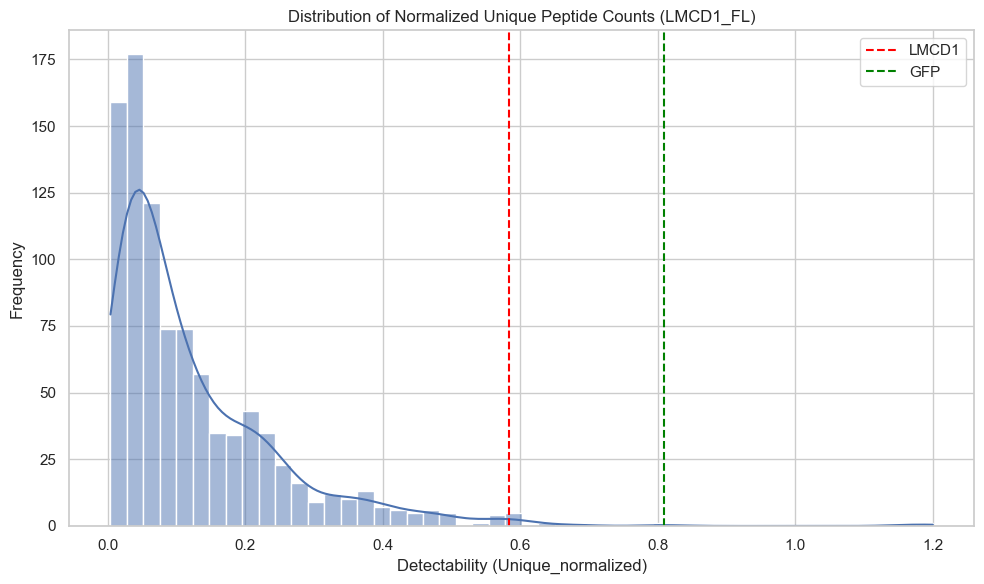

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_103016\1537798210.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged, x="Class", y="Unique_normalized", inner="box", palette=custom_palette)


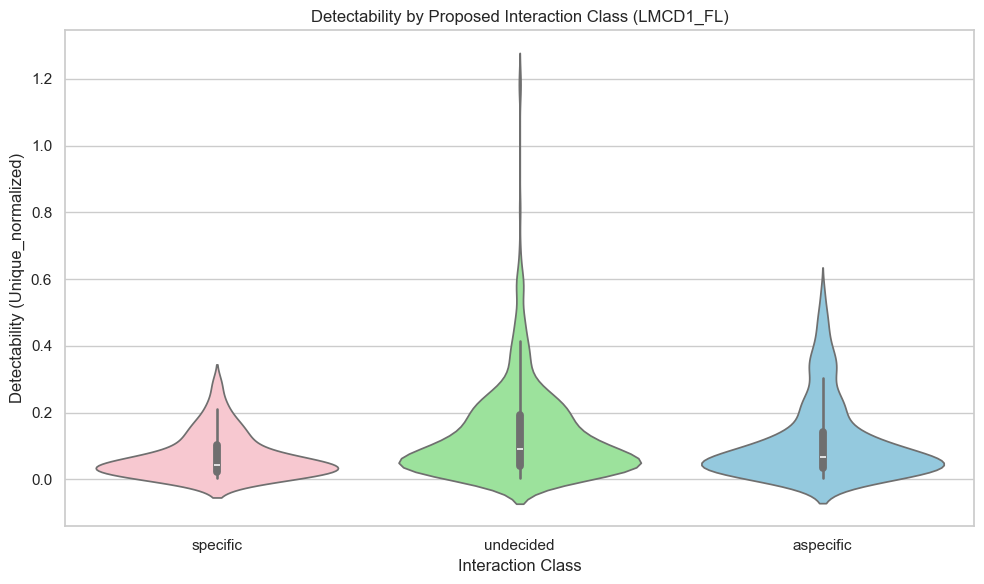

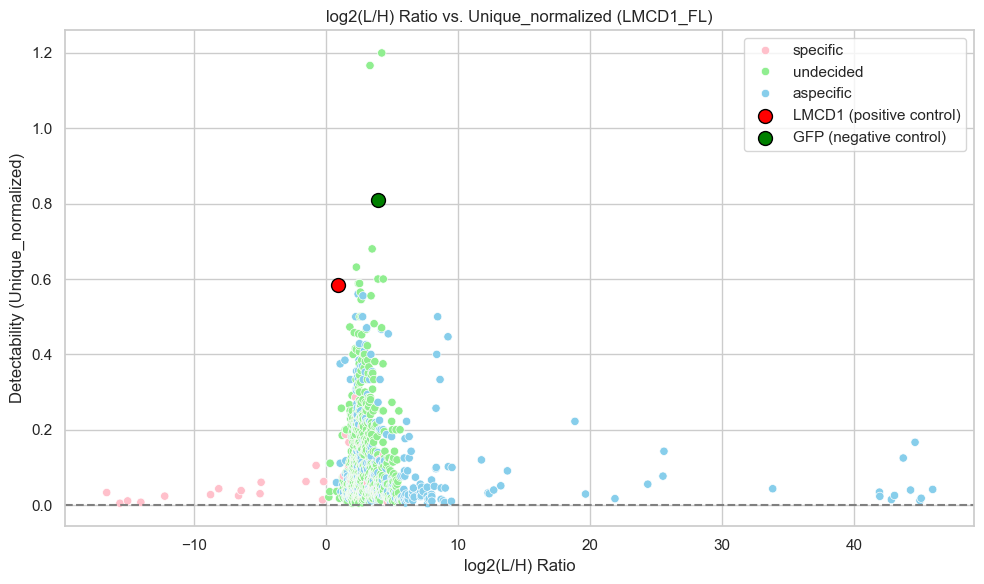

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyopenms import ProteaseDigestion, AASequence
import requests

# === STEP 1: LOAD INPUT DATA === (LMCD1_FL as example) (adjust as necessary for your directory structure)
dir = r'G:\My Drive\Uni\Thesis\Data\Testin_for_TVB\LMCD1 + TesCR\lmcd1_data'
proteins_df = pd.read_excel(dir + r'\Stefano_EXT983_LMCD1_FL.xlsx', sheet_name='proteins')

sheetnames = ['below_not_in_above', 'above_not_in_below', 'undecided_not_in_below_or_above'] # Specific, aspecific and undecided fraction, as determined through our own methodology.
lmcd1_fl_classif = {
    sheet_name: pd.read_excel(
        r"G:\My Drive\Uni\Thesis\Data\datasets_cutoff\final_results\Stefano_EXT983_LMCD1_FL_processed_results.xlsx",
        sheet_name=sheet_name
    ) for sheet_name in sheetnames
}

# === STEP 2: COMBINE 'CLASSIFIED' DATA ===
for sheet, label in zip(sheetnames, ['specific', 'aspecific', 'undecided']):
    lmcd1_fl_classif[sheet]['Class'] = label

classified_df = pd.concat(lmcd1_fl_classif.values(), ignore_index=True)

# === STEP 3: MERGE CLASSIFICATION WITH PROTEIN DATA ===
merged = proteins_df.merge(classified_df[['accession', 'Class']], on='accession', how='inner')

# === STEP 4: MANUALLY FIX ACCESSION MAPPING FOR POIs ===
# P0001 = GFP, P0002 = LMCD1
merged.loc[merged['accession'] == 'P0001', 'accession'] = 'P42212'  # GFP UniProt ID
merged.loc[merged['accession'] == 'P0002', 'accession'] = 'Q9NZV8'  # LMCD1 UniProt ID

# === STEP 5: FETCH SEQUENCES FROM UNIPROT ===
def fetch_sequence(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    try:
        response = requests.get(url)
        if response.ok:
            lines = response.text.splitlines()
            return ''.join(lines[1:])  # skip FASTA header
        else:
            return None
    except:
        return None

if "Sequence" not in merged.columns:
    merged["Sequence"] = merged["accession"].apply(fetch_sequence)

# === Step 5.1: Check for and remove proteins with missing sequences ===
merged = merged.dropna(subset=["Sequence"])

# === STEP 6: NORMALIZE UNIQUE PEPTIDE COUNTS ===
def normalize_unique_peptides(df, accession_col="accession", unique_count_col="Unique count(sequence)", min_peptide_length=3):
    digestion = ProteaseDigestion()
    digestion.setEnzyme("Trypsin")
    digestion.setMissedCleavages(0)

    def count_long_peptides(sequence, min_length=min_peptide_length):
        if sequence is None:
            return 0
        try:
            aa_sequence = AASequence.fromString(sequence)
            peptides = []
            digestion.digest(aa_sequence, peptides)
            return len([pep for pep in peptides if len(str(pep)) > min_length])
        except:
            return 0

    df["Theoretical_Peptide_Count"] = df["Sequence"].apply(count_long_peptides)
    df["Unique_normalized"] = df[unique_count_col] / df["Theoretical_Peptide_Count"]
    return df

merged = normalize_unique_peptides(merged)

# === STEP 7: PLOTTING WITH CONTROL HIGHLIGHTS ===
sns.set(style="whitegrid")

# Identify LMCD1 and GFP rows
lmcd1 = merged[merged["accession"] == "Q9NZV8"]
gfp = merged[merged["accession"] == "P42212"]

# Plot 1: Distribution of Unique_normalized
plt.figure(figsize=(10, 6))
sns.histplot(merged["Unique_normalized"], bins=50, kde=True)
plt.title("Distribution of Normalized Unique Peptide Counts (LMCD1_FL)")
plt.xlabel("Detectability (Unique_normalized)")
plt.ylabel("Frequency")
plt.axvline(lmcd1["Unique_normalized"].values[0], color='red', linestyle='--', label='LMCD1')
plt.axvline(gfp["Unique_normalized"].values[0], color='green', linestyle='--', label='GFP')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Violin plot by true class
# Custom color palette
custom_palette = {
    "specific": "pink",
    "undecided": "lightgreen",
    "aspecific": "skyblue"
}
plt.figure(figsize=(10, 6))
sns.violinplot(data=merged, x="Class", y="Unique_normalized", inner="box", palette=custom_palette)
plt.title("Detectability by Proposed Interaction Class (LMCD1_FL)")
plt.xlabel("Interaction Class")
plt.ylabel("Detectability (Unique_normalized)")
plt.tight_layout()
plt.show()

# Plot 3: Scatterplot of log2(L/H) vs Unique_normalized
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged,
    x="Median(log2(q.ratio))",
    y="Unique_normalized",
    hue="Class",
    palette=custom_palette
)
plt.scatter(
    lmcd1["Median(log2(q.ratio))"],
    lmcd1["Unique_normalized"],
    color='red',
    s=100,
    label='LMCD1 (positive control)',
    edgecolor='black'
)
plt.scatter(
    gfp["Median(log2(q.ratio))"],
    gfp["Unique_normalized"],
    color='green',
    s=100,
    label='GFP (negative control)',
    edgecolor='black'
)
plt.title("log2(L/H) Ratio vs. Unique_normalized (LMCD1_FL)")
plt.xlabel("log2(L/H) Ratio")
plt.ylabel("Detectability (Unique_normalized)")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
print(merged["Unique_normalized"].min(), merged["Unique_normalized"].max())

0.00390625 1.2


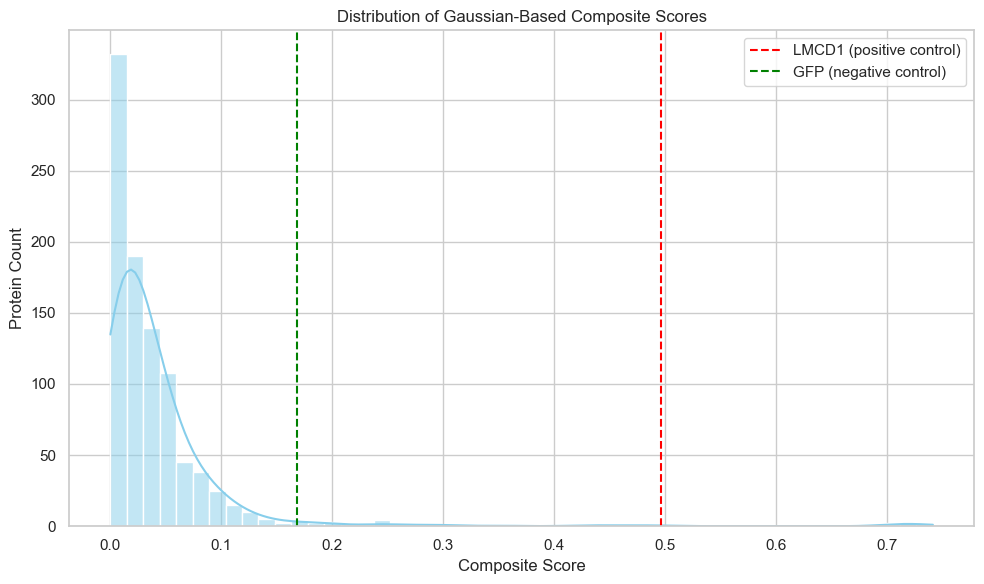

,accession,First(description),Median(log2(q.ratio)),Standard deviation(log2(q.ratio)),Mean(l_projectid),Count(filename),Unique count(sequence),Class,Sequence,Theoretical_Peptide_Count,Unique_normalized,S_LH_gauss,S_peptides_norm,Composite_score_gauss
14,Q99961,SH3G1_HUMAN Endophilin-A2,-0.178600,0.290830,7111.0,3,2,specific,MSVAGLKKQFYKASQLVSEKVGGAEGTKLDDDFKEMEKKVDVTSKA...,32,0.062500,0.972044,0.048988,0.741280
16,P84090,ERH_HUMAN Enhancer of rudimentary homolog,0.263575,0.000000,7111.0,4,1,aspecific,MSHTILLVQPTKRPEGRTYADYESVNECMEGVCKMYEEHLKRMNPN...,9,0.111111,0.940115,0.089629,0.727494
15,Q9Y2W1,TR150_HUMAN Thyroid hormone receptor-associate...,0.208055,0.067648,7111.0,3,2,undecided,MSKTNKSKSGSRSSRSRSASRSRSRSFSKSRSRSRSLSRSRKRRLS...,94,0.021277,0.962254,0.014523,0.725321
18,P28482,MK01_HUMAN Mitogen-activated protein kinase 1,0.305487,0.120719,7111.0,4,3,undecided,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,27,0.111111,0.920394,0.089629,0.712703
17,Q9NYF8,BCLF1_HUMAN Bcl-2-associated transcription fac...,0.275630,0.226602,7111.0,4,3,undecided,MGRSNSRSHSSRSKSRSQSSSRSRSRSHSRKKRYSSRSRSRTYSRS...,84,0.035714,0.934699,0.026593,0.707673


In [4]:
# === Composite Score Distribution Visualization ===
# This section calculates a biologically informed composite score based on 
# Gaussian-transformed enrichment and normalized peptide evidence.
# It then visualizes the overall distribution of these scores using a histogram,
# highlighting known positive (LMCD1) and negative (GFP) controls.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Gaussian enrichment score ===
# Highest at log2(L/H) = 0; decays symmetrically as values deviate
def gaussian_score(x, mu=0, sigma=0.75):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

merged["S_LH_gauss"] = gaussian_score(merged["Median(log2(q.ratio))"])

# === STEP 2: Normalize Unique_normalized peptide count ===
pep_min = merged["Unique_normalized"].min()
pep_max = merged["Unique_normalized"].max()
merged["S_peptides_norm"] = (merged["Unique_normalized"] - pep_min) / (pep_max - pep_min)

# === STEP 3: Composite score (Gaussian version) ===
merged["Composite_score_gauss"] = 0.75 * merged["S_LH_gauss"] + 0.25 * merged["S_peptides_norm"]

# === STEP 4: Identify control proteins ===
lmcd1 = merged[merged["accession"] == "Q9NZV8"]
gfp = merged[merged["accession"] == "P42212"]

# === STEP 5: Plot composite score distribution (Gaussian version) ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(merged["Composite_score_gauss"], bins=50, kde=True, color='skyblue')
if not lmcd1.empty:
    plt.axvline(lmcd1["Composite_score_gauss"].values[0], color='red', linestyle='--', label='LMCD1 (positive control)')
if not gfp.empty:
    plt.axvline(gfp["Composite_score_gauss"].values[0], color='green', linestyle='--', label='GFP (negative control)')
plt.title("Distribution of Gaussian-Based Composite Scores")
plt.xlabel("Composite Score")
plt.ylabel("Protein Count")
plt.legend()
plt.tight_layout()
plt.show()

# === Export or rank by composite score ===
ranked = merged.sort_values(by="Composite_score_gauss", ascending=False)
ranked.head()


In [5]:
# Save the ranked dataframe to an Excel file
ranked.to_excel(dir + r'\Stefano_EXT983_LMCD1_FL_ranked.xlsx', index=False)

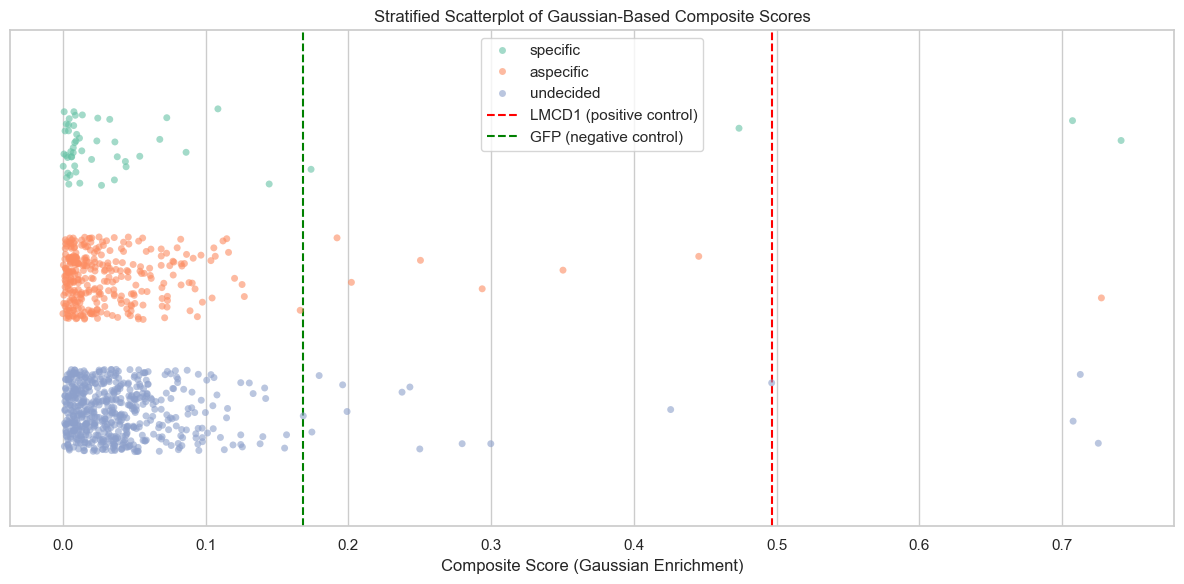

In [6]:
# === Composite Score Stratified by Classification ===
# This section recomputes the composite score ( if necessary) and visualizes its distribution 
# across predefined protein classes (e.g., specific, aspecific, undecided)
# using a horizontal stripplot. LMCD1 and GFP controls are highlighted to assess 
# how well the score aligns with expectations.


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Recalculate Gaussian composite score if needed ===
def gaussian_score(x, mu=0, sigma=0.75):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

ranked["S_LH_gauss"] = gaussian_score(ranked["Median(log2(q.ratio))"])

# Normalize Unique_normalized to [0, 1]
pep_min = ranked["Unique_normalized"].min()
pep_max = ranked["Unique_normalized"].max()
ranked["S_peptides_norm"] = (ranked["Unique_normalized"] - pep_min) / (pep_max - pep_min)

# Composite score using Gaussian-transformed enrichment
ranked["Composite_score_gauss"] = 0.75 * ranked["S_LH_gauss"] + 0.25 * ranked["S_peptides_norm"]

# === STEP 2: Create the stratified scatterplot ===
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=ranked,
    x="Composite_score_gauss",
    y=[""] * len(ranked),
    hue="Class",
    jitter=0.25,
    alpha=0.6,
    palette="Set2",
    dodge=True
)

# Highlight LMCD1 and GFP
lmcd1_score = ranked.loc[ranked["accession"] == "Q9NZV8", "Composite_score_gauss"].values[0]
gfp_score = ranked.loc[ranked["accession"] == "P42212", "Composite_score_gauss"].values[0]

plt.axvline(lmcd1_score, color='red', linestyle='--', label='LMCD1 (positive control)')
plt.axvline(gfp_score, color='green', linestyle='--', label='GFP (negative control)')

plt.title("Stratified Scatterplot of Gaussian-Based Composite Scores")
plt.xlabel("Composite Score (Gaussian Enrichment)")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_103016\1757570583.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


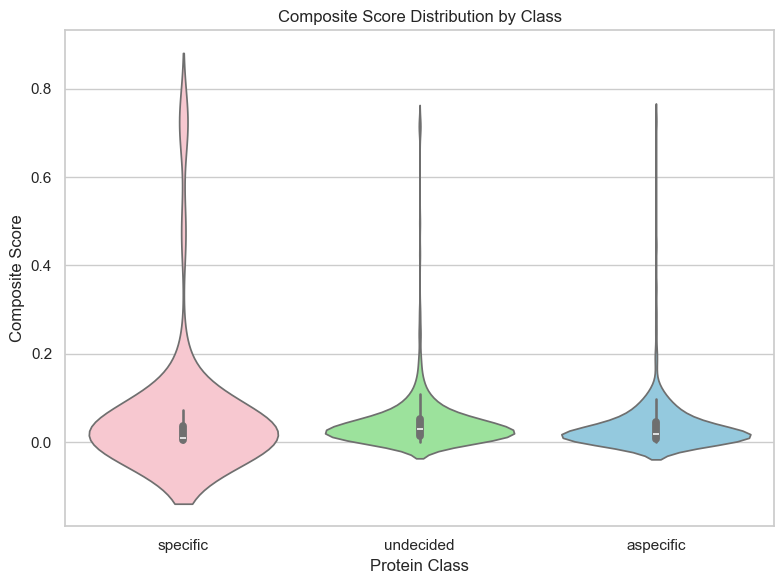

In [7]:
# === Composite Score Violin Plot by Classification ===
# This plot compares the distribution of Gaussian-based composite scores across 
# protein classes (specific, undecided, aspecific). It provides a visual check 
# on how well the score reflects the class separation established by the cutoff method.
# Useful for identifying overlap or misclassifications in the scoring scheme.

import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette for Class
custom_palette = {
    "specific": "pink",
    "undecided": "lightgreen",
    "aspecific": "skyblue"
}

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=ranked,
    x="Class",
    y="Composite_score_gauss",
    palette=custom_palette,
    inner="box",
    order=["specific", "undecided", "aspecific"],
)

plt.ylabel("Composite Score")
plt.xlabel("Protein Class")
plt.title("Composite Score Distribution by Class")
plt.tight_layout()
plt.show()
